<a href="https://colab.research.google.com/github/MizanMustakim/Big_Data_project_summer_semester/blob/main/Big_data_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection work

**Import the libraries**

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import urllib

**Collecting DATA_1**

In [2]:
url = "https://www.worldometers.info/coronavirus/?utm_campaign=homeAdvegas1?%22%20%5Cl%22countries"
data = requests.get(url)
soup = BeautifulSoup(data.text,'html5lib')

In [3]:
covid_dict = {}
div = soup.find_all("div", {"id": "ExplorerContainer"})
for i in div:
  content_div = i.find("div",{"class":"tableTab"})
  covid_dict[i.find("h1").text.replace(":","").strip()] = content_div.find("span").text.strip()

In [4]:
tables = soup.find_all('table')
table_header = tables[0].find_all('th')
table_head = []
for i in range(15):
  if i != 0:
    table_head.append(table_header[i].text.replace("\n","").replace("\xa0",""))
print(table_head)

['Country,Other', 'TotalCases', 'NewCases', 'TotalDeaths', 'NewDeaths', 'TotalRecovered', 'NewRecovered', 'ActiveCases', 'Serious,Critical', 'TotCases/1M pop', 'Deaths/1M pop', 'TotalTests', 'Tests/1M pop', 'Population']


In [5]:
Covid_data = pd.DataFrame(columns=table_head)
for row in tables[0].tbody.find_all('tr'):
  col = row.find_all('td')
  if (col != []):
    country = col[1].text.strip()
    totalCases = col[2].text.strip()
    newCases = col[3].text.strip()
    totalDeaths = col[4].text.strip()
    newDeaths = col[5].text.strip()
    totalRecovered = col[6].text.strip()
    newRecovered = col[7].text.strip()
    activeCases = col[8].text.strip()
    serious = col[9].text.strip()
    totalCases_per_m = col[10].text.strip()
    deaths = col[11].text.strip()
    totalTests = col[12].text.strip()
    tests_per_m = col[13].text.strip()
    population = col[14].text.strip()
    Covid_data = Covid_data.append({"Country,Other":country,"TotalCases":totalCases,"NewCases":newCases,
                                    "TotalDeaths":totalDeaths,"NewDeaths":newDeaths,"TotalRecovered":totalRecovered,
                                    "NewRecovered":newRecovered,"ActiveCases":activeCases,"Serious,Critical":serious,
                                    "TotCases/1M pop":totalCases_per_m,"Deaths/1M pop":deaths,"TotalTests":totalTests,
                                    "Tests/1M pop":tests_per_m,"Population":population},ignore_index=True)

In [6]:
Covid_data.drop(Covid_data.index[:7],inplace=True)
Covid_data.to_csv("Covid_data.csv",index=False)

**Collecting DATA_2**

In [7]:
!wget --no-check-certificate \
  https://covid.ourworldindata.org/data/owid-covid-data.csv \
  -O /content/owid-covid-data.csv

--2021-09-26 07:18:33--  https://covid.ourworldindata.org/data/owid-covid-data.csv
Resolving covid.ourworldindata.org (covid.ourworldindata.org)... 104.21.233.137, 104.21.233.138, 2606:4700:3038::6815:e989, ...
Connecting to covid.ourworldindata.org (covid.ourworldindata.org)|104.21.233.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘/content/owid-covid-data.csv’

/content/owid-covid     [    <=>             ]  30.91M  50.8MB/s    in 0.6s    

2021-09-26 07:18:34 (50.8 MB/s) - ‘/content/owid-covid-data.csv’ saved [32408093]



# Data Processing Work

**Install PySpark**

In [8]:
!pip install pyspark

     |████████████████████████████████| 212.4 MB 74 kB/s 
     |████████████████████████████████| 198 kB 46.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=d450b2b744b80f8bc2ecca44ed37a78100e82191606e32c9c9404f6d217bc1e5
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


**Importing Libraries**

In [9]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DecimalType, LongType
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains
from pyspark.sql.functions import regexp_replace, regexp_extract, col
from pyspark.sql.types import IntegerType

**Pre-processing DATA with PySpark**

**vaccine Data**

Reading the vaccination csv data in **PySpark**

In [10]:
spark = SparkSession.builder.appName('CSV reader').getOrCreate()

#extract
df = '/content/owid-covid-data.csv'
sdfData = spark.read.csv(df, header=True, sep=",").cache()
sdfData = sdfData.withColumnRenamed("location", "Country")

sdfData.show(10)

+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+---------+-----------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+----------------+----------+------------------+----------+----

Checking the Schema of the created dataframe

In [11]:
sdfData.printSchema()

root
 |-- iso_code: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: string (nullable = true)
 |-- total_cases: string (nullable = true)
 |-- new_cases: string (nullable = true)
 |-- new_cases_smoothed: string (nullable = true)
 |-- total_deaths: string (nullable = true)
 |-- new_deaths: string (nullable = true)
 |-- new_deaths_smoothed: string (nullable = true)
 |-- total_cases_per_million: string (nullable = true)
 |-- new_cases_per_million: string (nullable = true)
 |-- new_cases_smoothed_per_million: string (nullable = true)
 |-- total_deaths_per_million: string (nullable = true)
 |-- new_deaths_per_million: string (nullable = true)
 |-- new_deaths_smoothed_per_million: string (nullable = true)
 |-- reproduction_rate: string (nullable = true)
 |-- icu_patients: string (nullable = true)
 |-- icu_patients_per_million: string (nullable = true)
 |-- hosp_patients: string (nullable = true)
 |-- hosp_patients_per_million:

Separate the new_vaccination info of the day before the current day from data table.

In [12]:
#transform
sdfData.registerTempTable("vaccine")

vaccine_data = spark.sql('SELECT continent, Country, new_vaccinations, total_vaccinations, people_vaccinated, population from vaccine WHERE date = "2021-09-22"AND continent<>"null"' )


vaccine_data.show(10)

+-------------+-------------------+----------------+------------------+-----------------+----------+
|    continent|            Country|new_vaccinations|total_vaccinations|people_vaccinated|population|
+-------------+-------------------+----------------+------------------+-----------------+----------+
|         Asia|        Afghanistan|            null|              null|             null|39835428.0|
|       Europe|            Albania|          8503.0|         1674093.0|         926652.0| 2872934.0|
|       Africa|            Algeria|            null|              null|             null|44616626.0|
|       Europe|            Andorra|            null|              null|             null|   77354.0|
|       Africa|             Angola|            null|              null|             null|33933611.0|
|North America|           Anguilla|            null|              null|             null|   15125.0|
|North America|Antigua and Barbuda|            null|              null|             null|  

Checking the schema of the new DataFrame

In [13]:
vaccine_data.printSchema()

root
 |-- continent: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- new_vaccinations: string (nullable = true)
 |-- total_vaccinations: string (nullable = true)
 |-- people_vaccinated: string (nullable = true)
 |-- population: string (nullable = true)



Converting the string data type into the integer data type of new_vaccination data and population data.

In [14]:
data = ["new_vaccinations", "total_vaccinations", "people_vaccinated", "population"]

for i in data:
    vaccine_data = vaccine_data.withColumn(i, vaccine_data[i].cast(IntegerType()))

Now again check the schema, and get the difference.

In [15]:
vaccine_data.printSchema()

root
 |-- continent: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- new_vaccinations: integer (nullable = true)
 |-- total_vaccinations: integer (nullable = true)
 |-- people_vaccinated: integer (nullable = true)
 |-- population: integer (nullable = true)



Now replace the null values with zero(0)

In [16]:
vaccine_data = vaccine_data.fillna(value=0)
vaccine_data.show()

+-------------+-------------------+----------------+------------------+-----------------+----------+
|    continent|            Country|new_vaccinations|total_vaccinations|people_vaccinated|population|
+-------------+-------------------+----------------+------------------+-----------------+----------+
|         Asia|        Afghanistan|               0|                 0|                0|  39835428|
|       Europe|            Albania|            8503|           1674093|           926652|   2872934|
|       Africa|            Algeria|               0|                 0|                0|  44616626|
|       Europe|            Andorra|               0|                 0|                0|     77354|
|       Africa|             Angola|               0|                 0|                0|  33933611|
|North America|           Anguilla|               0|                 0|                0|     15125|
|North America|Antigua and Barbuda|               0|                 0|                0|  

Checking the DataFrame shape

In [17]:
print((vaccine_data.count(), len(vaccine_data.columns)))

(202, 6)


Storing the pre-processed data into the data warehouse.

In [18]:
vaccine_data.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("vaccine_data.csv")

# Covid Data

Load the csv file of covid data in **PySpark**

In [19]:
spark = SparkSession.builder.appName('CSV reader').getOrCreate()

#extract
df = '/content/Covid_data.csv'
covid_dfData = spark.read.csv(df, header=True, sep=",").cache()

covid_dfData.show(4)

+-------------+-----------+--------+-----------+---------+--------------+------------+-----------+----------------+---------------+-------------+-----------+------------+-------------+
|Country,Other| TotalCases|NewCases|TotalDeaths|NewDeaths|TotalRecovered|NewRecovered|ActiveCases|Serious,Critical|TotCases/1M pop|Deaths/1M pop| TotalTests|Tests/1M pop|   Population|
+-------------+-----------+--------+-----------+---------+--------------+------------+-----------+----------------+---------------+-------------+-----------+------------+-------------+
|        World|232,295,615| +43,541|  4,757,625|     +992|   208,911,749|     +49,825| 18,626,241|          94,836|         29,801|        610.4|       null|        null|         null|
|          USA| 43,725,604|    null|    706,058|     null|    33,162,044|        null|  9,857,502|          22,377|        131,153|        2,118|631,838,920|   1,895,167|  333,394,863|
|        India| 33,652,745|  +1,524|    446,948|     null|    32,902,351|  

Lets change the Column name from "Country,other" to "Country"

In [20]:
covid_dfData = covid_dfData.withColumnRenamed("Country,Other", "Country")
covid_dfData.show(4)

+-------+-----------+--------+-----------+---------+--------------+------------+-----------+----------------+---------------+-------------+-----------+------------+-------------+
|Country| TotalCases|NewCases|TotalDeaths|NewDeaths|TotalRecovered|NewRecovered|ActiveCases|Serious,Critical|TotCases/1M pop|Deaths/1M pop| TotalTests|Tests/1M pop|   Population|
+-------+-----------+--------+-----------+---------+--------------+------------+-----------+----------------+---------------+-------------+-----------+------------+-------------+
|  World|232,295,615| +43,541|  4,757,625|     +992|   208,911,749|     +49,825| 18,626,241|          94,836|         29,801|        610.4|       null|        null|         null|
|    USA| 43,725,604|    null|    706,058|     null|    33,162,044|        null|  9,857,502|          22,377|        131,153|        2,118|631,838,920|   1,895,167|  333,394,863|
|  India| 33,652,745|  +1,524|    446,948|     null|    32,902,351|      +7,589|    303,446|           8,

Separate the columns named "Country", "TotalCases", "NewCases", "NewDeaths", "TotalDeaths", "TotalRecovered" from the data frame. And convert them from string data type into integer data type, excxept the column named "Country".

In [21]:
covid_selected_data = covid_dfData["Country", "TotalCases", "NewCases", "NewDeaths", "TotalDeaths", "TotalRecovered"]

In [22]:
data = ["TotalCases", "NewCases", "NewDeaths", "TotalDeaths", "TotalRecovered"]

for i in data:
    covid_selected_data = covid_selected_data.withColumn(i, regexp_replace(i, ',', ''))
    covid_selected_data = covid_selected_data.withColumn(i, covid_selected_data[i].cast(IntegerType()))

In [23]:
covid_selected_data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- TotalCases: integer (nullable = true)
 |-- NewCases: integer (nullable = true)
 |-- NewDeaths: integer (nullable = true)
 |-- TotalDeaths: integer (nullable = true)
 |-- TotalRecovered: integer (nullable = true)



In [24]:
covid_selected_data.show()

+------------+----------+--------+---------+-----------+--------------+
|     Country|TotalCases|NewCases|NewDeaths|TotalDeaths|TotalRecovered|
+------------+----------+--------+---------+-----------+--------------+
|       World| 232295615|   43541|      992|    4757625|     208911749|
|         USA|  43725604|    null|     null|     706058|      33162044|
|       India|  33652745|    1524|     null|     446948|      32902351|
|      Brazil|  21343304|    null|     null|     594246|      20333908|
|          UK|   7631233|    null|     null|     136105|       6159135|
|      Russia|   7398415|    null|     null|     203095|       6590933|
|      Turkey|   7013639|    null|     null|      62938|       6472400|
|      France|   6989613|    null|     null|     116449|       6720003|
|        Iran|   5519728|    null|     null|     119082|       4920978|
|   Argentina|   5249840|    null|     null|     114849|       5109853|
|    Colombia|   4950253|    null|     null|     126102|       4

Fill the null value with zero(0).

In [25]:
covid_selected_data = covid_selected_data.fillna(value=0)
covid_selected_data.show(10)

+---------+----------+--------+---------+-----------+--------------+
|  Country|TotalCases|NewCases|NewDeaths|TotalDeaths|TotalRecovered|
+---------+----------+--------+---------+-----------+--------------+
|    World| 232295615|   43541|      992|    4757625|     208911749|
|      USA|  43725604|       0|        0|     706058|      33162044|
|    India|  33652745|    1524|        0|     446948|      32902351|
|   Brazil|  21343304|       0|        0|     594246|      20333908|
|       UK|   7631233|       0|        0|     136105|       6159135|
|   Russia|   7398415|       0|        0|     203095|       6590933|
|   Turkey|   7013639|       0|        0|      62938|       6472400|
|   France|   6989613|       0|        0|     116449|       6720003|
|     Iran|   5519728|       0|        0|     119082|       4920978|
|Argentina|   5249840|       0|        0|     114849|       5109853|
+---------+----------+--------+---------+-----------+--------------+
only showing top 10 rows



Storing the pre-processed data into the data warehouse.

In [26]:
covid_selected_data.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("covid_data.csv")

# Now concatening these two datasets what we have pre-processed above. And process them.

In [27]:
final_df = covid_selected_data.join(vaccine_data, ["Country"], how="outer")
final_df.show()

+----------------+----------+--------+---------+-----------+--------------+-------------+----------------+------------------+-----------------+----------+
|         Country|TotalCases|NewCases|NewDeaths|TotalDeaths|TotalRecovered|    continent|new_vaccinations|total_vaccinations|people_vaccinated|population|
+----------------+----------+--------+---------+-----------+--------------+-------------+----------------+------------------+-----------------+----------+
|            Chad|      5031|       0|        0|        174|          4850|       Africa|               0|                 0|                0|  16914985|
|        Anguilla|       364|       0|        0|          1|           345|North America|               0|                 0|                0|     15125|
|        Paraguay|    459804|       0|        0|      16142|        442632|South America|               0|                 0|                0|   7219641|
|          Russia|   7398415|       0|        0|     203095|       659

Checking the final dataframe's size

In [28]:
print((final_df.count(), len(final_df.columns)))

(240, 11)


Dropping all NA values from the column named "Population", so that we can get all country data except other data.

In [29]:
final_df = final_df.na.drop(subset=["population"])
final_df.show()

+-------------------+----------+--------+---------+-----------+--------------+-------------+----------------+------------------+-----------------+----------+
|            Country|TotalCases|NewCases|NewDeaths|TotalDeaths|TotalRecovered|    continent|new_vaccinations|total_vaccinations|people_vaccinated|population|
+-------------------+----------+--------+---------+-----------+--------------+-------------+----------------+------------------+-----------------+----------+
|        Afghanistan|    155132|       0|        0|       7198|        123639|         Asia|               0|                 0|                0|  39835428|
|            Albania|    167354|       0|        0|       2629|        152780|       Europe|            8503|           1674093|           926652|   2872934|
|            Algeria|    202574|       0|        0|       5767|        138737|       Africa|               0|                 0|                0|  44616626|
|            Andorra|     15167|       0|        0| 

Now checking again the dataframe's size

In [30]:
print((final_df.count(), len(final_df.columns)))

(202, 11)


The following code is to get the list data of any particular column. Here we tried to get the distinct data of continent column.

In [31]:
continent = final_df.select("continent").distinct().rdd.flatMap(list).collect()
print("Total number of continent: ",len(continent))
print(continent)

Total number of continent:  6
['Europe', 'Africa', 'North America', 'South America', 'Oceania', 'Asia']


Getting the distinct data of country column.

In [32]:
country = final_df.select("country").distinct().rdd.flatMap(list).collect()
print("Total number of country: ",len(country))
print(country)

Total number of country:  202
['Chad', 'Anguilla', 'Paraguay', 'Russia', 'Yemen', 'Senegal', 'Sweden', 'Kiribati', 'Guyana', 'Eritrea', 'Philippines', 'Djibouti', 'Malaysia', 'Singapore', 'Fiji', 'Turkey', 'Malawi', 'Iraq', 'Germany', 'Comoros', 'Afghanistan', 'Cambodia', 'Jordan', 'Maldives', 'Rwanda', 'Sudan', 'Palau', 'France', 'Greece', 'Kosovo', 'Sri Lanka', 'Dominica', 'Taiwan', 'Algeria', 'Equatorial Guinea', 'Togo', 'Slovakia', 'Argentina', 'Angola', 'Belgium', 'Vatican', 'San Marino', 'Ecuador', 'Qatar', 'Lesotho', 'Albania', 'Madagascar', 'Finland', 'Ghana', 'Myanmar', 'Nicaragua', 'Guernsey', 'Benin', 'Peru', 'Sierra Leone', 'Bahamas', 'China', 'Curacao', 'India', 'United States', 'Belarus', 'Kuwait', 'Malta', 'Sao Tome and Principe', 'Marshall Islands', 'Somalia', 'Chile', 'Tajikistan', 'Cayman Islands', 'Isle of Man', 'Croatia', 'Burundi', 'Andorra', 'Bolivia', 'Nigeria', 'Gabon', 'Italy', 'Suriname', 'Lithuania', 'Norway', 'Spain', 'Cuba', 'Mauritania', 'Czechia', 'Centra

Save the data to the data warehouse

In [33]:
final_df.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").save("final_df_data.csv")

# Visualising the Data

Import libraries

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

Load the final dataset from data warehouse

In [35]:
spark = SparkSession.builder.appName('CSV reader').getOrCreate()

#extract
df = '/content/final_df_data.csv'
final_data = spark.read.csv(df, header=True, sep=",").cache()

final_data.show(40)

+--------------------+----------+--------+---------+-----------+--------------+-------------+----------------+------------------+-----------------+----------+
|             Country|TotalCases|NewCases|NewDeaths|TotalDeaths|TotalRecovered|    continent|new_vaccinations|total_vaccinations|people_vaccinated|population|
+--------------------+----------+--------+---------+-----------+--------------+-------------+----------------+------------------+-----------------+----------+
|         Afghanistan|    155132|       0|        0|       7198|        123639|         Asia|               0|                 0|                0|  39835428|
|             Albania|    167354|       0|        0|       2629|        152780|       Europe|            8503|           1674093|           926652|   2872934|
|             Algeria|    202574|       0|        0|       5767|        138737|       Africa|               0|                 0|                0|  44616626|
|             Andorra|     15167|       0|    

Checking if there are any inetger column in string format.

In [36]:
final_data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- TotalCases: string (nullable = true)
 |-- NewCases: string (nullable = true)
 |-- NewDeaths: string (nullable = true)
 |-- TotalDeaths: string (nullable = true)
 |-- TotalRecovered: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- new_vaccinations: string (nullable = true)
 |-- total_vaccinations: string (nullable = true)
 |-- people_vaccinated: string (nullable = true)
 |-- population: string (nullable = true)



Since there are some string columns yet. So first convert them into integer type, and then replace null value with 0.

In [37]:
data = ["TotalCases", "NewCases", "NewDeaths", "TotalDeaths", "TotalRecovered", "new_vaccinations", "total_vaccinations", "people_vaccinated", "population"]

for i in data:
    final_data = final_data.withColumn(i, final_data[i].cast(IntegerType()))

In [38]:
final_data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- TotalCases: integer (nullable = true)
 |-- NewCases: integer (nullable = true)
 |-- NewDeaths: integer (nullable = true)
 |-- TotalDeaths: integer (nullable = true)
 |-- TotalRecovered: integer (nullable = true)
 |-- continent: string (nullable = true)
 |-- new_vaccinations: integer (nullable = true)
 |-- total_vaccinations: integer (nullable = true)
 |-- people_vaccinated: integer (nullable = true)
 |-- population: integer (nullable = true)



In [39]:
final_data = final_data.na.fill(value=0)

***Total Death analysis on different continent.***

Separate them from the data table.

In [40]:
final_data.registerTempTable("final_data")
c = spark.sql("SELECT continent, SUM(TotalDeaths) as TotalDeaths, \
              SUM(total_vaccinations) as total_vaccinations, \
              SUM(TotalRecovered) as TotalRecovered \
              FROM final_data \
              GROUP BY continent")
c.show()

+-------------+-----------+------------------+--------------+
|    continent|TotalDeaths|total_vaccinations|TotalRecovered|
+-------------+-----------+------------------+--------------+
|       Europe|    1078914|         643484827|      47393918|
|       Africa|     206418|         113370061|       7407532|
|North America|     359393|         597598113|       7428456|
|South America|    1151463|         171506192|      33963322|
|      Oceania|       2074|          25445232|        133609|
|         Asia|    1107082|        1532664954|      70248777|
+-------------+-----------+------------------+--------------+



Storing the data into the variables, so that later we can plot them.

In [41]:
total_death = c.select("TotalDeaths").rdd.flatMap(list).collect()
continent = c.select("continent").rdd.flatMap(list).collect()
total_vaccinations = c.select("total_vaccinations").rdd.flatMap(list).collect()
TotalRecovered = c.select("TotalRecovered").rdd.flatMap(list).collect()

Visualizing the death rate on every region by Pie Chart.

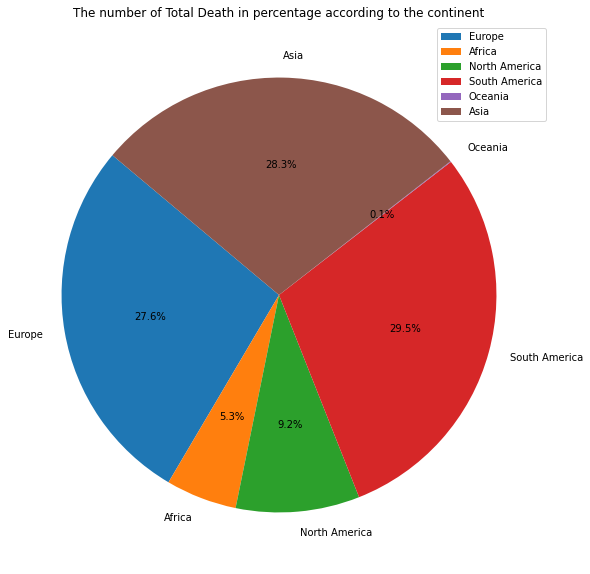

In [42]:
fig = plt.figure(figsize=(12, 10))
plt.pie(total_death, autopct='%1.1f%%', startangle=140, radius=1, labels=continent)
plt.title("The number of Total Death in percentage according to the continent")
plt.legend()
plt.show()

Visualizing the vaccination rate on every region in Bar plot.

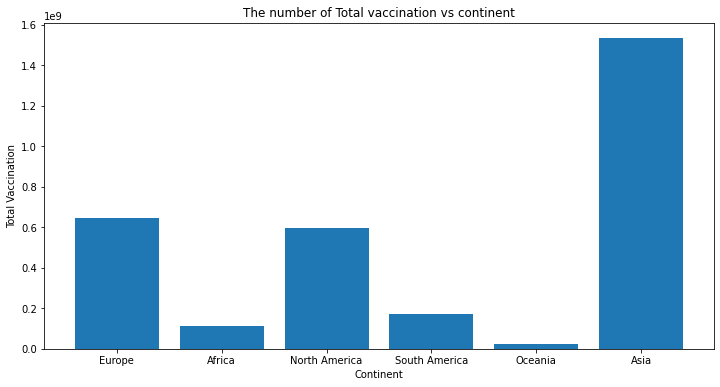

In [45]:
fig = plt.figure(figsize=(12, 6))

plt.bar(continent,total_vaccinations)
plt.xlabel("Continent")
plt.ylabel("Total Vaccination")
plt.title("The number of Total vaccination vs continent")
plt.show()

A graphical presentation of the Covid-19 scenario on every region.

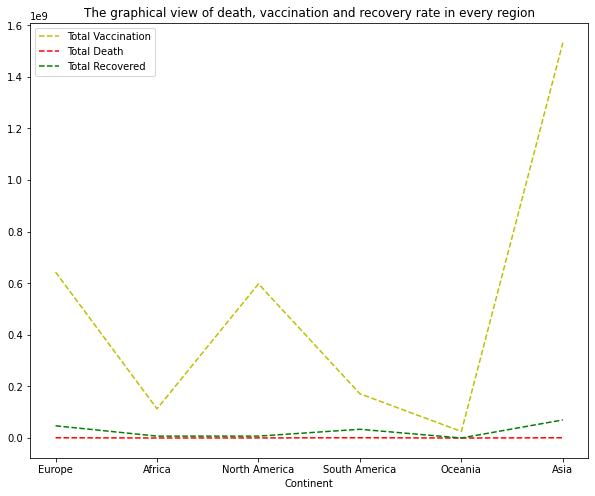

In [51]:
fig = plt.figure(figsize=(10, 8))

plt.plot(continent,total_vaccinations, "y--", label="Total Vaccination")
plt.plot(continent,total_death, "r--", label="Total Death")
plt.plot(continent,TotalRecovered, "g--", label="Total Recovered")
plt.xlabel("Continent")
plt.legend()
plt.title("The graphical view of death, vaccination and recovery rate in every region")
plt.show()